In [33]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

# Analysis of the effect of the candidate vote share

## Data wrangling

In [2]:
src = "../data"
fname = "KnowWho_profiles_merged_twitter.csv"
knowwho_profiles = pd.read_csv(
    Path(src, fname), 
    dtype={"author_id":str},
    parse_dates=["created_at", "ELECTIONDATE"]
)

In [3]:
knowwho_profiles["STATUS"].value_counts()

STATUS
Running               1426
Withdrew From Race     168
Name: count, dtype: int64

In [4]:
knowwho_profiles = knowwho_profiles[knowwho_profiles["STATUS"] == "Running"].reset_index(drop=True)
knowwho_profiles = knowwho_profiles.drop(columns=["STATUS", "ELECTIONCODE"])
knowwho_profiles = knowwho_profiles.dropna(subset=["handle"])
# note: it is necessary to have a double-index, since there is one candidate
# (farrforus) who ran in two elections
knowwho_profiles = knowwho_profiles.set_index(["handle", "ELECTIONDATE"])

In [5]:
len(knowwho_profiles)

1204

### Add information from vote share research

The table `primaries_for_margin_research_RW.csv` was coded by Richard Westway (email on 2023-06-14) who added the columns VOTE_SHARE, NOTES, and COMPLETE. The corresponding email chain is archived in `Projects/CSS_honesty/analysis/midterms/reg_report/`.
* VOTE_SHARE: percentage of the votes gathered by the candidate
* NOTES on various corrections and special election types. Legend:
    * A – Candidate advanced
    * C – Primary cancelled and candidate advanced
    * D# – Corrected district id for this candidate
    * DUP – Duplicate candidate entry
    * NL – Candidate not listed in results
    * NP – Vote share from Nonpartisan Primary
    * R# – Candidate advanced to Primary runoff followed by runoff vote share
    * RCV1 – Vote share from 1st round of ranked-choice voting
    * S-## - Corrected state for this candidate
    * UW – Candidate unofficially withdrew
    * WD – Candidate withdrawn or disqualified
* COMPLETE: disregard, all rows are "Y"

JL updated the data to split the "NOTES" column into several columns, saved in the table `primaries_for_margin_research_RW_JL.csv`. The new table contains the following columns (next to the original VOTE_SHARE and updated NOTES):
* DISTRICT_CORR – contains the corrected district number, corresponding D# entries have been removed from the NOTES column
* STATE_CORR – contains the corrected state acronym, corresponding S# entries have been removed from the NOTES column
* NP – contains a 1 if it was a nonpartisan primary, corresponding NP entries have been removed from the NOTES column
* RCV1 – contains a 1 if it was a ranked-choice voting, corresponding RCV1 entries have been removed from the NOTES column
* RUNOFF_PERC – contains the percentage of the runoff vote share, corresponding R# entries have been removed from the NOTES column

In [47]:
fname = "primaries_for_margin_research_RW_JL.csv"
margins = pd.read_csv(Path(src, fname), parse_dates=["ELECTIONDATE"], dayfirst=True)
margins = margins.drop(columns="COMPLETE")
margins = margins.dropna(subset=["handle"])
margins = margins.set_index(["handle", "ELECTIONDATE"])
margins.head(3)

,,name,PARTY,STATEABBR,RACE,DISTRICT,VOTE_SHARE,NOTES,NONPARTISAN_PRIMARY,DISTRICT_CORR,STATE_CORR,RUNOFF_PERC,RANKED_CHOICE_VOTING
handle,ELECTIONDATE,,,,,,,,,,,,
carlforalabama,2022-05-24,Jerry L. Carl,R,AL,US Representative,1.0,NaN,C,NaN,NaN,NaN,NaN,NaN
terellanderson,2022-05-24,Reginald Terell Anderson,D,AL,US Representative,2.0,NaN,WD,NaN,NaN,NaN,NaN,NaN
phyllisdhhall,2022-05-24,Phyllis Harvey-Hall,D,AL,US Representative,2.0,68.8,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# correct district entries
knowwho_profiles = knowwho_profiles.sort_index()
margins = margins.sort_index()
for handle, electiondate in knowwho_profiles.index:
    if not np.isnan(margins.loc[(handle, electiondate), "DISTRICT_CORR"].values[0]):
        district = margins.loc[(handle, electiondate), "DISTRICT_CORR"].values[0]
        knowwho_profiles.loc[(handle, electiondate), "DISTRICT"] = district

In [8]:
# correct state entries
for handle, electiondate in knowwho_profiles.index:
    if not np.isnan(margins.loc[(handle, electiondate), "STATE_CORR"].values[0]):
        state = margins.loc[(handle, electiondate), "STATE_CORR"].values[0]
        knowwho_profiles.loc[(handle, electiondate), "STATE"] = state

In [9]:
# add ranked-choice voting entries, notes, non-partisan election entries,
# percentages from runoff votes, and vote shares
knowwho_profiles["RANKED_CHOICE_VOTING"] = np.nan
knowwho_profiles["NOTES"] = np.nan
knowwho_profiles["NOTES"] = knowwho_profiles["NOTES"].astype(object)
knowwho_profiles["NONPARTISAN_PRIMARY"] = np.nan
knowwho_profiles["RUNOFF_PERC"] = np.nan
knowwho_profiles["VOTE_SHARE"] = np.nan

for handle, electiondate in knowwho_profiles.index:
    knowwho_profiles.loc[(handle, electiondate), "RANKED_CHOICE_VOTING"] = \
        margins.loc[(handle, electiondate), "RANKED_CHOICE_VOTING"].values[0]
    knowwho_profiles.loc[(handle, electiondate), "NOTES"] = \
        margins.loc[(handle, electiondate), "NOTES"].values[0]
    knowwho_profiles.loc[(handle, electiondate), "NONPARTISAN_PRIMARY"] = \
        margins.loc[(handle, electiondate), "NONPARTISAN_PRIMARY"].values[0]
    knowwho_profiles.loc[(handle, electiondate), "VOTE_SHARE"] = \
        margins.loc[(handle, electiondate), "VOTE_SHARE"].values[0]

In [10]:
del margins

In [11]:
# remove all candidates that don't have a vote share
knowwho_profiles = knowwho_profiles.dropna(subset=["VOTE_SHARE"])

# remove all candidates that got a vote share of 100%
knowwho_profiles = knowwho_profiles[knowwho_profiles["VOTE_SHARE"] != 100]

In [12]:
knowwho_profiles["NOTES"].value_counts()

NOTES
UW    4
Name: count, dtype: int64

In [13]:
knowwho_profiles["PARTY"].value_counts()

PARTY
R    457
D    340
Name: count, dtype: int64

In [14]:
knowwho_profiles["INCUMBENT"].value_counts()

INCUMBENT
Y    228
Name: count, dtype: int64

In [15]:
len(knowwho_profiles)

797

### Calculate the number of tweets before the election

In [16]:
fname = "midterm_tweets_2022-01-01_to_2023-05-01.csv.gzip"
tweets = pd.read_csv(
    Path(src, fname),
    dtype={"id":str, "author_id":str},
    parse_dates=["created_at"],
    compression="gzip"
)

In [18]:
tweets = tweets[tweets["tweet_length"] > 10]

In [17]:
knowwho_profiles["N_tweets_leadup"] = np.nan

In [19]:
# note: it is necessary to have a double-index, since there is one candidate
# (farrforus) who ran in two elections
i = 0
for handle, electiondate in knowwho_profiles.index:
    if i%100 == 0:
        print(f"{i}/{len(knowwho_profiles)}")
    # select only tweets of the candidate from the four weeks leading up to the 
    # election date
    candidate_tweets = tweets[tweets["handle"] == handle]
    candidate_tweets = candidate_tweets[
        (candidate_tweets["created_at"].dt.date <= electiondate.date()) & \
        (candidate_tweets["created_at"].dt.date >= electiondate.date() - pd.Timedelta(days=28))
    ]
    knowwho_profiles.loc[(handle, electiondate), "N_tweets_leadup"] = len(candidate_tweets)
    i += 1

0/797
100/797
200/797
300/797
400/797
500/797
600/797
700/797


In [20]:
len(knowwho_profiles[knowwho_profiles["N_tweets_leadup"] > 0])

672

In [21]:
knowwho_profiles[knowwho_profiles["N_tweets_leadup"] > 0]["INCUMBENT"].value_counts()

INCUMBENT
Y    190
Name: count, dtype: int64

In [22]:
knowwho_profiles[knowwho_profiles["N_tweets_leadup"] > 0]["PARTY"].value_counts()

PARTY
R    374
D    298
Name: count, dtype: int64

In [23]:
knowwho_profiles["N_tweets_leadup"].mean()

57.43412797992472

In [24]:
knowwho_profiles["N_tweets_leadup"].std()

100.22803016021851

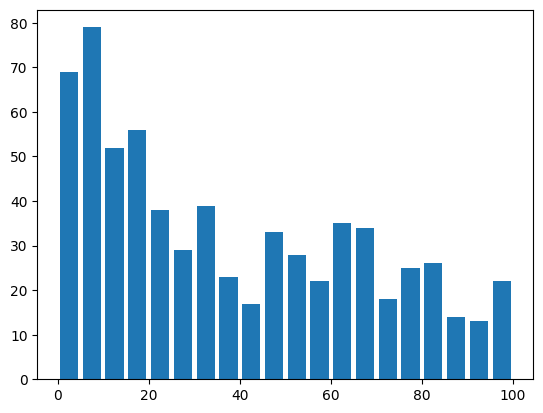

In [25]:
fig, ax = plt.subplots()
ax.hist(knowwho_profiles[knowwho_profiles["N_tweets_leadup"] > 0]["VOTE_SHARE"], bins=range(0, 101, 5), rwidth=0.8);

## Power analysis

### Linear mixed effects model simulation

In [26]:
# define simulation parameters
n_sim = 100  # number of simulations
alpha = 0.05  # significance level
subset = knowwho_profiles[knowwho_profiles["N_tweets_leadup"] > 0]
n_incumbents = len(subset[subset["INCUMBENT"] == "Y"])
n_democrats = len(subset[subset["PARTY"] == "D"])

# sample sizes
n_groups = len(subset)

# variance components
var_intercept = 0.001967
var_residual = 0.013305959951221604

In [27]:
def simulate_lme(params):
    random_state, beta_v, beta_P, beta_vP = params

    n_obs_per_group = subset["N_tweets_leadup"]\
        .sample(n_groups, random_state=random_state)\
        .values.astype(int)
    total_n = n_obs_per_group.sum()    
        
    # generate simulated data before election
    group = np.repeat(np.arange(n_groups), n_obs_per_group)
    
    # continuous predictor sampled from distribution of vote_shares
    vote_share = np.repeat(subset["VOTE_SHARE"]\
        .sample(n=n_groups, replace=True).values / 100, n_obs_per_group)
    
    # binary predictor P sampled from distribution of party affiliations
    P_group = np.random.binomial(1, n_democrats/ n_groups, n_groups)  
    P_observations = np.repeat(P_group, n_obs_per_group)

    # random effects
    random_intercepts = np.random.normal(0, np.sqrt(var_intercept), n_groups)
    random_effects = random_intercepts[group]
    errors = np.random.normal(0, np.sqrt(var_residual), total_n)

    # calculate dependent variable
    D = (0 + \
         beta_v * vote_share + beta_P * P_observations + \
         beta_vP * vote_share * P_observations + \
         random_effects + errors)

    # put everything together in a data frame
    data = pd.DataFrame({'D':D, 'C':group, 'v':vote_share,'P':P_observations})

    # fit the linear mixed effects model
    model = smf.mixedlm("D ~ v * P", data, groups=data["C"])
    result = model.fit()    

    # assess significance of the effects, handle cases where the term is not estimable
    try:
        p_value_v = result.pvalues['v']
    except KeyError:
        p_value_v = np.nan
    try:
        p_value_P = result.pvalues['P']
    except KeyError:
        p_value_P = np.nan
    try:
        p_value_vP = result.pvalues['v:P']
    except KeyError:
        p_value_VP = np.nan

    return (random_state, beta_v, beta_P, beta_vP, p_value_v, p_value_P, p_value_vP)

In [43]:
beta_vs = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06]
beta_Ps = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06]
beta_vPs = [0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06]

random_states = range(n_sim)

params = [(i, beta_vs[j], beta_Ps[j], beta_vPs[j])\
              for j in range(len(beta_vs))\
              for i in random_states] 
N_configs = len(params)

In [ ]:
results = pd.DataFrame()
pool = Pool(10)

for tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7 in tqdm(pool.imap_unordered(
    func=simulate_lme, 
    iterable=params), 
    total=N_configs):

    results = pd.concat([results, pd.DataFrame({
        "random_state":[tmp1],
        "beta_v":[tmp2],
        "beta_P":[tmp3],
        "beta_vP":[tmp4],
        "p_value_v":[tmp5],
        "p_value_P":[tmp6],
        "p_value_vP":[tmp7]
    })])

pool.close()

results["alpha"] = alpha
results["var_intercept"] = var_intercept
results["var_residual"] = var_residual
fname = "vote_share_power_analysis.csv"
results.to_csv(Path("../results", fname), index=False)

### Calculate power

In [30]:
# calculate power
results = pd.read_csv("../results/vote_share_power_analysis.csv")
power = pd.DataFrame()

for beta_v, beta_P, beta_vP in zip(beta_vs, beta_Ps, beta_vPs):
    res = results[
        (results["beta_v"] == beta_v) & \
        (results["beta_P"] == beta_P) & \
        (results["beta_vP"] == beta_vP)
    ]

    power_v = np.nanmean(res["p_value_v"].values < alpha)
    power_P = np.nanmean(res["p_value_P"].values < alpha)
    power_vP = np.nanmean(res["p_value_vP"].values < alpha)
    
    power = pd.concat([power, pd.DataFrame({
        "beta_v":[beta_v],
        "beta_P":[beta_P],
        "beta_vP":[beta_vP],
        "power_v":[power_v],
        "power_P":[power_P],
        "power_vP":[power_vP]
    })])

In [45]:
# calculate power bootstrapped
results = pd.read_csv("../results/vote_share_power_analysis.csv")
power_bootstrap = pd.DataFrame()

n_bootstrap = 100
for beta_v, beta_P, beta_vP in zip(beta_vs, beta_Ps, beta_vPs):
    for n in range(n_bootstrap):
        res = results[
            (results["beta_v"] == beta_v) & \
            (results["beta_P"] == beta_P) & \
            (results["beta_vP"] == beta_vP)
        ].sample(frac=1, replace=True)
    
        power_v = np.nanmean(res["p_value_v"].values < alpha)
        power_P = np.nanmean(res["p_value_P"].values < alpha)
        power_vP = np.nanmean(res["p_value_vP"].values < alpha)
        
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$v$"],
            "effect":[beta_v],
            "power":[power_v],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$P$"],
            "effect":[beta_P],
            "power":[power_P],
        })])
        power_bootstrap = pd.concat([power_bootstrap, pd.DataFrame({
            "variable":["$v \\times P$"],
            "effect":[beta_vP],
            "power":[power_vP]
        })])

In [38]:
power_bootstrap = power_bootstrap[power_bootstrap["effect"] < 0.08]

### Visualisation of power analysis

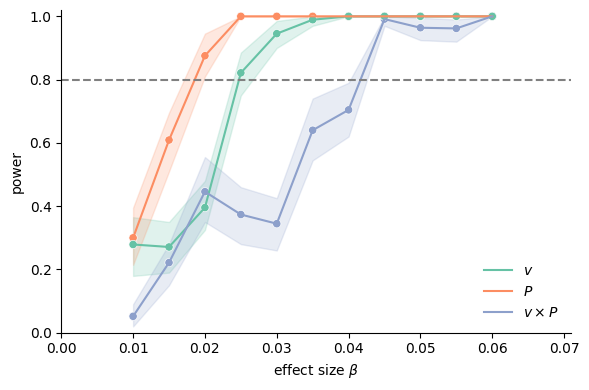

In [46]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=power_bootstrap,
    ax=ax,
    x="effect", 
    y="power",
    hue="variable",
    errorbar="pi",
    palette="Set2",
)

sns.scatterplot(
    data=power_bootstrap.groupby(["variable", "effect"]).mean().reset_index(),
    ax=ax,
    x="effect",
    y="power",
    hue="variable",
    hue_order=["$v$", "$P$", "$v \\times P$"],
    sizes=[50, 50, 50],
    palette="Set2",
    legend=False
)

ax.set_xlabel("effect size $\\beta$")
ax.spines[['right', 'top']].set_visible(False)
ax.legend(frameon=False)
ax.plot([0, 0.071], [0.8, 0.8], '--', color="grey")
ax.set_xlim(0, 0.071)
ax.set_ylim(0, 1.02)
plt.tight_layout()

fname = "power_analysis_vote_share"
dst = "../plots"
plt.savefig(Path(dst, fname + ".pdf"))
plt.savefig(Path(dst, fname + ".svg"))

## Main analysis

TODO